## Analysis of flat10MIP output

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','tab:yellow']


In [3]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [4]:
# initialize a dictionary to hold all of the data
data_dict={}

In [5]:
# other info that I don't think is necessary - delete later

# python dislikes filenames with dashes
modellist_safe = ['ACCESS',
                  'CESM2',
                  'CNRM',
                  'GFDL',
                  'GISS',
                  'NorESM2']

caltype = ['DatetimeProlepticGregorian',
           'DatetimeNoLeap',
           'DatetimeGregorian',
           'DatetimeNoLeap',
           'year',
           'DatetimeNoLeap']

startdate = [101, 1, 1850, 1, 1850, 1850]


### Define Functions

In [6]:
def weighted_temporal_mean(ds, var):
    """
    takes an annual average weighted by days in each month

    Args:
    - dataset: xarray dataset with monthly resolution data
    - var: variable name to be averaged

    Returns:
    - the weighted average

    Example Usage: 
    
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="YS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="YS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [7]:
def select_time_slice(dataset, startyear, endyear):
    """
    Selects the years between start year and end year
    of data from an xarray dataset.
    start year references 0 as the first year
    
    Args:
    - dataset: xarray dataset containing the time dimension
    
    Returns:
    - time_slice: xarray dataset containing the years of data between startyear and endyear

    Example usage:
    Assuming you have a list of xarray datasets called 'datasets'
    first_10_years_datasets = [select_first_10_years(dataset,startyear,endyear) for dataset in datasets]
    alternatively just retrieve a time slice for one dataset at a time
    """

    # GISS originally did not have a cftime index. I now add one when data is loaded for GISS
    # This part of the loop should now be obselete, suggest deleting later.
    # Check if the dataset has a dimension labeled "time"
    if 'time' not in dataset.dims:
        print('time is not defined as cftime in this dataset')
        # if the model is GISS, then it does not have a cftime time index 
        # and instead just an index of years
        # also the first many enties of time are empty, so force the start date of 1850
        time_coord = dataset.year.values
        time_slice = dataset.sel(year=slice(1850 + startyear, 1850 + endyear))

    else:
        # model uses cftime
        # Extract the time coordinate from the dataset
        time_coord = dataset.time.values
        
        # Determine the calendar type of the dataset
        calendar_type = time_coord[0].calendar
        
        # Calculate the end date for the first 10 years based on the calendar type
        if calendar_type in ['standard', 'gregorian', 'proleptic_gregorian']:
            start_date = cftime.DatetimeGregorian(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.DatetimeGregorian(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        elif calendar_type == 'noleap':
            start_date = cftime.DatetimeNoLeap(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.DatetimeNoLeap(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        elif calendar_type in ['365_day','360_day']:
            start_date = cftime.Datetime360Day(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.Datetime360Day(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        # Add more conditions for other calendar types if needed
        
        # Select the time slice
        time_slice = dataset.sel(time=slice(start_date, end_date))
    
    return time_slice


### Load grid info

In [8]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    print(model +' getting grid info')
    # get land fraction
    filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
    landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)

    # get area of gridcells
    filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
    areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    ## get area of ocean gridcells
    #filenamelist= glob.glob(outputdir +model +'/*/*areacello*.nc')
    #areacello = xr.open_dataset(filenamelist[0], use_cftime=True)
    #if model =='CESM2':
    #    areacello=areacello*1e-4 # CESM2 has area units of cm2 for ocean

    #----correct the name of the lat lon dimensions for landfrac and areacella
    if ((model =='HadCM3LC-Bris') and ('lat' not in landfrac)):
        #-- change latitude and longitude to lat and lon for HadCM3
        landfrac = landfrac.rename({'longitude': 'lon','latitude': 'lat'})
        areacella = areacella.rename({'longitude': 'lon','latitude': 'lat'})
        #-- change name of area fields to match other models
        areacella = areacella.rename({'cell_area': 'areacella'})
        landfrac = landfrac.rename({'land_area_fraction': 'sftlf'})

    if (model =='GISS_E2.1'):
        # lon is -180 to 180 in data but 0 to 360 in grid files =>convert
        areacella['lon']=areacella['lon']-180
        landfrac['lon']=landfrac['lon']-180
        #landfrac['lon']=landfrac['lon']-180
        #landfrac.reindex_like(areacella, method='nearest',tolerance=0.05)

    # add to the dictionary
    data_dict[model +'_areacella'] = areacella
    data_dict[model +'_landfrac'] = landfrac
    #data_dict[model +'_areacello'] = areacello

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info


### Load data

In [9]:
# this loads all variables in varlist for all experiments in runlist and models in modellist

#modellist=['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR']
#modellist=['HadCM3LC-Bris']
#----loop over models----#

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for r in range(len(runlist)):
        run = runlist_wc[r]
        print('loading run: ' +run)
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist_load[v]
            print('loading variable: ' +var)
            
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            #----loop over filenames----#
            # some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            #----- Dealing with GISS----#
            # GISS does not have a "time" index, and instead just a list of years
            # lets replace the "year" dimension (data is called "years")
            # with a cftime object called "time" so it matches the other models
            # some variables don't have the variable that defines years at all
            if ((model == 'GISS_E2.1') and ('time' not in dsmerge_f)):         
                if 'year' in dsmerge_f: # if it has a variable called year, use that to make the time index
                    time_index = [cftime.DatetimeNoLeap(year, 1, 1) for year in dsmerge_f.year]
                else: # if it does not have a variable for year, use the size of the year dimension to make the time index
                    startyear=[1850, 1950, 1950] # these are the start years for each experiment for GISS
                    years = np.arange(startyear[r], startyear[r]+len(dsmerge_f['year']))
                    time_index = [cftime.DatetimeNoLeap(year, 1, 1) for year in years]
                
                # Create a new DataArray with cftime objects
                time_da = xr.DataArray(time_index, dims='year')
                # Add time_da as a coordinate to the dataset
                dsmerge_f.coords['time'] = time_da
                # Now, swap dimensions from 'years' to 'time'
                dsmerge_f = dsmerge_f.swap_dims({'year': 'time'})
                # drop the year variable
                #dsmerge_f = dsmerge_f.drop_vars('year')
            
            #----correct the name of the lat lon dimensions
            if ((model =='HadCM3LC-Bris') and ('lat' not in dsmerge_f)):
                #-- change latitude and longitude to lat and lon for HadCM3
                dsmerge_f = dsmerge_f.rename({'longitude': 'lon','latitude': 'lat'})
            
            #----correct variable names----# 
            if 'nep' in dsmerge_f: # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep') # to remove it from the dataset
            
            if model =='HadCM3LC-Bris':
                if 'GBMVegCarb_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['cVeg'] = dsmerge_f['GBMVegCarb_srf']
                if 'soilCarbon_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['cSoil'] = dsmerge_f['soilCarbon_srf']
                if 'NPP_mm_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['npp'] = dsmerge_f['NPP_mm_srf']
                if 'unknown' in dsmerge_f: #HadCM3 
                    dsmerge_f['nbp'] = dsmerge_f['unknown']
                if 'field1560_mm_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['fgco2'] = dsmerge_f['field1560_mm_srf']
                if 'soilResp_mm_srf' in dsmerge_f: #HadCM3 cSoil
                    dsmerge_f['rh'] = dsmerge_f['soilResp_mm_srf']
                if 'GPP_mm_srf gpp' in dsmerge_f: #HadCM3 cSoil
                    dsmerge_f['gpp'] = dsmerge_f['GPP_mm_srf gpp']
                 
                
            #----check units and convert if necessary----#
            if var in dsmerge_f: 
                if model =='CESM2':
                    if dsmerge_f[var].units == 'gC/m^2/s':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                    # stock variables
                    elif dsmerge_f[var].units == 'gC/m^2':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2'

                # the units for cVeg in GISS look like they MUST be in gC rather than kgC 
                # CHANGING THE UNIT - even though it is reported as kgC, assuming it is in gC
                if ((var == 'cVeg') and (model == 'GISS_E2.1')):
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC

                
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                #else: # this should now be obsolete
                #    nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                #             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray
            
            #----merge all variables into one dataset----#
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                if (dsmerge_v['cLitter'].notnull().all()): #litter is sometimes missing. Would be good to make this more general but dealing with this problem for now.
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil']+dsmerge_v['cLitter'] 
                else: 
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil'] 
                
        #----save output to a dictionary----#
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v


modellist=modellist_orig
varlist=varlist_analyze

loading model: ACCESS-ESM1-5
loading run: *lat10
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10 to dict
loading run: *zec
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10_zec to dict
loading run: *cdr
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10_cdr to dict
loading model: CESM2
loading run: *lat10
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding CESM2 flat10 to dict
loading run: *zec
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding CESM2 flat10_ze

In [10]:
ds=data_dict[modellist[0] +'_' +runlist[0]]
ds


<xarray.Dataset>
Dimensions:    (time: 2400, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) object 0101-01-16 12:00:00 ... 0300-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 0101-01-01 00:00:00 ... 0301-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.38 -89.38 ... 89.38 90.0
    lon_bnds   (time, lon, bnds) float64 -0.9375 0.9375 0.9375 ... 357.2 359.1
    cVeg       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cSoil      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cLitter    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cTot       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    nep        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    nbp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    gpp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    rh         (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36524.0
    contact:                access_csiro@csiro.au
    ...                     ...
    variable_id:            cVeg
    variant_label:          r1i1p1f2
    version:                v20231220
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/bf249875-1619-427f-9b89-f01bdb599a9a

(0.0, 2.0)

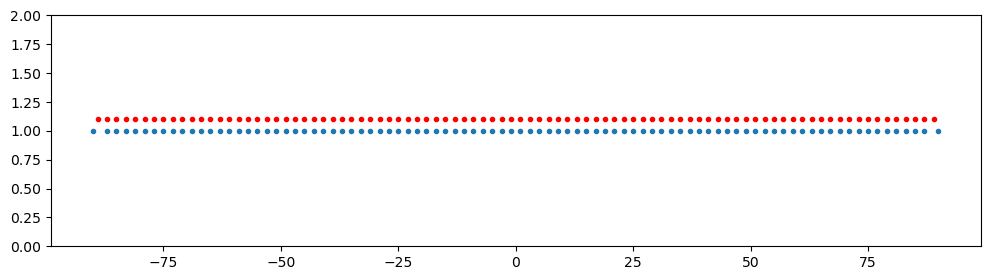

In [11]:
# grid for GISS has correct dimensions but different lat values at polar most gridcell
# the grid file came from PCMDI because GISS didn't supply a grid file
# not fixing this at the moment, but it could become a problem later

fig = plt.figure(figsize=(12,3))
ds= data_dict['GISS_E2.1_' +runlist[0]]
landfrac= data_dict['GISS_E2.1_' +'landfrac']

plt.plot(ds.lat,np.ones(len(ds.lat)),'.')
plt.plot(landfrac.lat,1.1*np.ones(len(landfrac.lat)),'.',color='red')
plt.ylim([0,2])


# Calculate Metrics

### zonal average land sink

Zonal average land sink is calculated from total carbon on land averaged into latitude bands

In [12]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])

# create a time series of years for the first dimension
ts= np.arange(350)

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for e in range(len(runlist)):
        run = runlist[e]
        print('loading run: ' +run)


        ds=data_dict[modellist[m] +'_' +runlist[e]]
        ds_area = data_dict[modellist[m] +'_' +'areacella']
        ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
        #area = ds_area['areacella'].expand_dims(dim={'time': ds.time.size}, axis=0)
        #landfrac=ds_landfrac['sftlf'].expand_dims(dim={'time': ds.time.size}, axis=0)
        
        
        if model=='CESM2':
            area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
        else:
            area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
        
        landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)
        
        if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
            landfrac=landfrac/100
            
        landarea=area*landfrac
        
        troplat=30
        highlat=60
        


        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            #print('loading variable: ' +var)

            data_var= weighted_temporal_mean(ds, var)

            # total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
            # our area variable is in m2
            C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
            C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
            C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
            C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])

            #put into matrix and convert to PgC (kgC => PgC, divide by 10^12)
            C_global_mat[0:len(C_global),m,e,v]= C_global*PgperKg
            C_highlat_mat[0:len(C_global),m,e,v]= C_highlat*PgperKg
            C_troplat_mat[0:len(C_global),m,e,v]= C_troplat*PgperKg
            C_midlat_mat[0:len(C_global),m,e,v]= C_midlat*PgperKg




## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

loading model: ACCESS-ESM1-5
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: CESM2
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: GFDL-ESM4
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: GISS_E2.1
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: NorESM2-LM
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: MPI-ESM1-2-LR
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: CNRM-ESM2-1
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: HadCM3LC-Bris
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr


In [13]:
ds_area

<xarray.Dataset>
Dimensions:         (lat: 73, lon: 96, bnds: 2)
Coordinates:
  * lat             (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon             (lon) float32 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
    surface         float32 ...
    time            object ...
Dimensions without coordinates: bnds
Data variables:
    areacella       (lat, lon) float32 ...
    latitude_bnds   (lat, bnds) float32 ...
    longitude_bnds  (lon, bnds) float64 ...
Attributes:
    date:         00/12/50
    history:      Tue Mar 25 03:22:23 GMT 2025 - XCONV V1.91 Development
    name:         cell_area
    source:       Unified Model Output (Vn 4.6):
    time:         00:00
    Conventions:  CF-1.7

In [14]:
# put the matrix into an xarray dataset
latlist=['global','highlat','troplat','midlat']

data_array_combined = np.full((len(ts), len(modellist), len(runlist), len(varlist), len(latlist)),np.nan)

data_array_combined[:,:,:,:,0]=C_global_mat
data_array_combined[:,:,:,:,1]=C_highlat_mat
data_array_combined[:,:,:,:,2]=C_troplat_mat
data_array_combined[:,:,:,:,3]=C_midlat_mat

In [15]:
np.shape(data_array_combined)

(350, 8, 3, 7, 4)

In [16]:


ds_C_global= xr.Dataset(
    {
        "data": (["time", "model", "run", "var","latrange"], data_array_combined)
    },
    coords={
        "time": ts,
        "model": modellist,
        "run": runlist,
        "var": varlist,
        "latrange": latlist
    }
)

In [17]:
ds_C_global

<xarray.Dataset>
Dimensions:   (time: 350, model: 8, run: 3, var: 7, latrange: 4)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 342 343 344 345 346 347 348 349
  * model     (model) <U13 'ACCESS-ESM1-5' 'CESM2' ... 'HadCM3LC-Bris'
  * run       (run) <U10 'flat10' 'flat10_zec' 'flat10_cdr'
  * var       (var) <U7 'cVeg' 'cSoil' 'cTot' 'cLitter' 'nbp' 'gpp' 'rh'
  * latrange  (latrange) <U7 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 645.3 38.02 ... 0.0 nan

In [18]:
# - save the matrix to a netcdf file

ds_C_global.to_netcdf("C_metrics_matrix.nc")

<xarray.Dataset>
Dimensions:   (time: 350)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 342 343 344 345 346 347 348 349
    model     <U13 'ACCESS-ESM1-5'
    run       <U10 'flat10'
    var       <U7 'cTot'
    latrange  <U7 'global'
Data variables:
    data      (time) float64 1.47e+03 1.47e+03 1.471e+03 ... 0.0 0.0 0.0


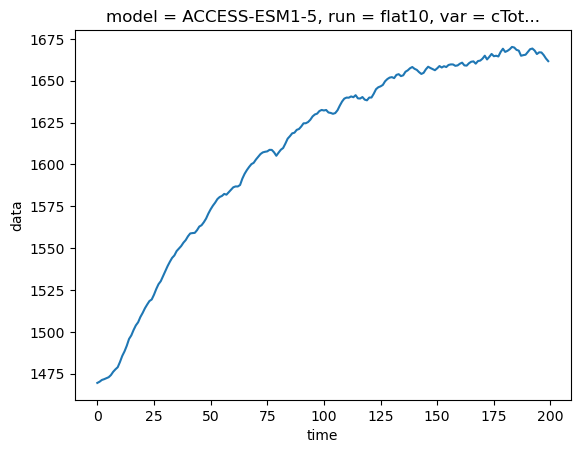

In [19]:
# to load data from this ds

# Access data for one model, run, var, latrange

subset = ds_C_global.sel(model=modellist[0], run=runlist[0], var='cTot', latrange='global')

print(subset)

subset.data[0:200].plot()

# #---------# Snippets below #-----------#